<a href="https://colab.research.google.com/github/jvallalta/ia3/blob/main/6_Weather_Hampton_TF_Ejercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<strong><center>Previsión meteorológica en Hampton</center></strong>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

## Introducción

Ene ste ejercicio trata de predecir el tiempo futuro de una ciudad utilizando datos meteorológicos históricos de la propia ciudad.

Como trabajaremos con secuencias de longitud arbitraria, utilizaremos una Red Neuronal Recurrente (RNN).

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


In [3]:
#download_dir = "/content/"
#path = os.path.join(download_dir, "/content/3317898170868.csv")
#if os.path.exists(path):
#    df = pd.read_pickle(path)
#else:
df = pd.read_csv('3317898170868.csv', delim_whitespace=True)
df = df.filter(['YR--MODAHRMN', 'TEMP'])
df = df.rename(columns={df.columns[0]: "time",  df.columns[1]: 'temp'})
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d%H%M')
df = df.set_index(pd.DatetimeIndex(df['time']))
df = df.drop(['time'], axis=1)
df = df[df['temp'] != '****']
df = df.astype(int)
#df.to_pickle(path)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,6,11,21,24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,temp
time,
2017-01-01 02:55:00,46
2017-01-01 03:15:00,46
2017-01-01 03:35:00,46
2017-01-01 03:55:00,46
2017-01-01 04:15:00,44


Genera unas columnas nuevas con datos del dia del año, la hora y los minutos por separado para aprovecharlos como datos de entrada a la red

In [6]:
# Nuevas columnas
df['Day'] = df.index.dayofyear
df['Hour'] = df.index.hour
df['Minutes'] = df.index.minute
df.head()

,temp,Day,Hour,Minutes
time,,,,
2017-01-01 02:55:00,46,1,2,55
2017-01-01 03:15:00,46,1,3,15
2017-01-01 03:35:00,46,1,3,35
2017-01-01 03:55:00,46,1,3,55
2017-01-01 04:15:00,44,1,4,15


A partir del desplazamiento establecido, define los datos de entrenamiento y el target.

La columna target es `temp` pero recuerda desplazarla para cada muestra correspondientemente

In [7]:
shift_days = 1
shift_steps = shift_days * 24

target_names = ['temp']
df_targets = df[target_names].shift(-shift_steps)
x_data = df.values[0:-shift_steps]
y_data = df_targets.values[:-shift_steps]

Divide entrenemiento y test en un factor de 0.8

Escala los valores:

Training data:
x_data:  (62455, 4)
y_data:  (62455, 1)
Test data:
x_data:  (15614, 4)
y_data:  (15614, 1)


Esta función definida nos generará los lotes del tamaña especificado y con la secuencia que queremos

In [ ]:
def batch_generator(batch_size, sequence_length):
    while True:
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        for i in range(batch_size):
            idx = np.random.randint(num_train - sequence_length)
            x_batch[i] = x_train_scaled[idx:idx + sequence_length]
            y_batch[i] = y_train_scaled[idx:idx + sequence_length]
        yield x_batch, y_batch

Ajustamos alguns parámetros y generamos los datos

In [ ]:
batch_size = 32
sequence_length = 24 * 7 * 16
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)
validation_data = (np.expand_dims(x_test_scaled, axis=0), np.expand_dims(y_test_scaled, axis=0))

Definimos el modelo:(inicialmente con 2 capas, 64 neuronas)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 128)         51456     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 100)         12900     
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 1)           101       
Total params: 163,529
Trainable params: 163,529
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

Establece callbacks:

Entrena

La siguiente función nos ayuda a grficar

In [ ]:
def plot_comparison(start_idx, length=100, train=True):
    if train:
        x = x_train_scaled
        y_true = y_data[0:num_train]
    else:
        x = x_test_scaled
        y_true = y_data[num_train:]

    end_idx = start_idx + length
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

    for signal in range(len(target_names)):
        signal_pred = y_pred_rescaled[:, signal]
        signal_true = y_true[:, signal]
        plt.figure(figsize=(15, 5))
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        plt.ylabel(target_names[signal])
        plt.legend()
        #plt.savefig(
        #    str(target_names[signal]) + '_' + str(start_idx) + '_' + str("train" if train else "test") + ".png")
        #plt.close()
        plt.show()

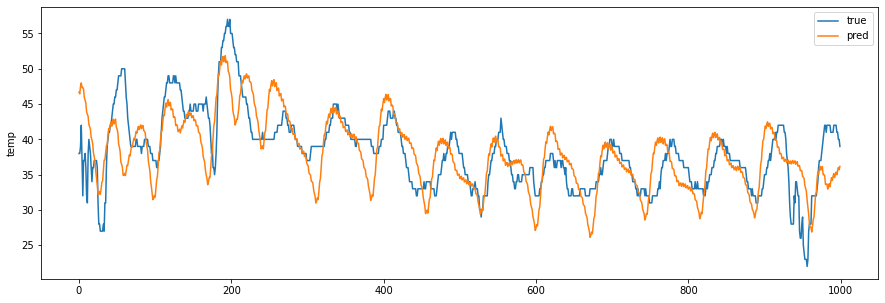

In [ ]:
plot_comparison(start_idx=30000, length=1000, train=True)
#plot_comparison(start_idx=40000, length=1000, train=True)

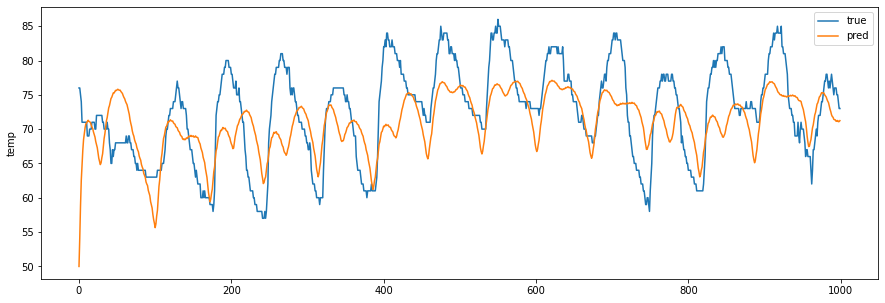

In [ ]:
plot_comparison(start_idx=4000, length=1000, train=False)
#plot_comparison(start_idx=5000, length=1000, train=False)
#plot_comparison(start_idx=6000, length=1000, train=False)

In [ ]:
#plot_comparison(start_idx=50000, length=5000, train=True)

## Referencias

* Doc oficial Pytorch https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

##Fin del cuaderno